<a href="https://colab.research.google.com/github/ibader85/PredictiveAnalytics/blob/main/19_Regression_Trees_Using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

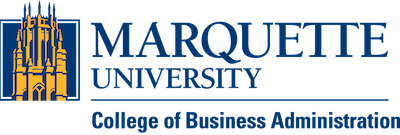

# BUAN 3065: Unlocking Business Insights with Predictive Analytics
# Regression Trees Using Python

Instructor: Dr. Badar Al Lawati

The algorithm for decision trees supports hyperparameter tuning
using the k-fold cross-validation method; therefore, we partition the
dataset into two parts:

- The training set is used to create one or
more models
- The validation set (referred to as the test set to
be consistent with the term used in Python packages) is employed
to assess model performance in unseen data

In this case, we split
the data in the Balance_Data worksheet into two segments: 70%
for training and 30% for test, and then apply the 10-fold crossvalidation
technique to identify the tree with optimal complexity

In [2]:
# Import the excel file into Colab

import pandas as pd
myData = pd.read_excel('/content/Balance.xlsx', sheet_name = 'Balance_Data')
myData.head()

,Age,Sex,Income,Balance
0,38,Female,60000,3250
1,20,Male,41000,3546
2,20,Female,134000,1094
3,29,Female,93000,5593
4,27,Female,47000,264


we use the Pandas get_dummies function
to convert the categorical Sex variable into a dummy variable.


Before performing dummy coding, we use the str.strip function
to remove leading and trailing whitespace from the Sex column
to ensure that there are no unwanted spaces around the values.


This is important because having leading or trailing spaces in
the value can cause unexpected issues or errors when you create
dummy variables.

Therefore, it is a good practice to clean the
data before encoding categorical data

The resulting dummy variable, Male, would have two possible
values, 0 (female) and 1 (male).

We then use the Pandas concat
function to concatenate myData and the new dummy variable.

Finally, we remove the original Sex column from the data frame
as it is no longer needed

In [3]:
myData.Sex = myData.Sex.str.strip()
myData = pd.concat([myData, pd.get_dummies(myData.Sex, drop_first = True)], axis = 1)
myData = myData.drop('Sex', axis = 1)

We partition the data into 70% training (X_train and y_train)
and 30% test (X_test and y_test) sets using Scikit-Learn’s
train_test_split function.

As usual, we set the random_state to a
fixed value, 321, to ensure that the data split remains the same
every time the code is executed.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(myData.drop('Balance', axis = 1), myData.Balance, test_size = 0.30, random_state = 321)

Use the len function to verify that there are 350 cases in the
training data set and 150 cases in the test data set

In [5]:
len(X_train)

350

In [6]:
len(X_test)

150

Let's import the DecisionTreeRegressor class and create a
variable of the regressor named RT_model.

We set the random
seed for the random number generator used by the decision tree
algorithm to 321 to ensure that the results are reproducible

In [7]:
from sklearn.tree import DecisionTreeRegressor
RT_model = DecisionTreeRegressor(random_state = 321)

If we fit (train) the decision tree regressor RT_model on the
training data, it would generate a default classification tree,
which is the full tree

Remember, a
full tree is overly complex and tends to overfit the data, resulting
in low predictive performance when applied to new cases.

Therefore, we skip the process of developing the default tree and
focus on identifying a tree with the optimal complexity in the
next step.

-----------------------------------

To identify a pruned tree with optimal complexity, we use the
hyperparameter tuning technique with 10-fold cross-validation as
we did in the classification tree example

In
Python, it is a common practice to include cost complexity
parameter (ccp_alpha) along with other hyperparameters when
tuning your model.

By searching over a range of values for these
hyperparameters, you can find the combination that results in
the best-performing pruned tree

we
include maximum depth (max_depth) and minimum samples of
leaf nodes (min_samples_leaf) as the two additional
hyperparameters.

Maximum depth controls how deep the
pruned tree can be, and minimum samples leaf specifies the
minimum number of samples required to be in a leaf node,
influencing the tree’s granularity.

To define a grid of
hyperparameter values, we create a dictionary variable,
paramGrid, to store the three hyperparameters and their ranges.


The range for the ccp_alpha value is set by using
CT_model.cost_complexity_pruning_path(X_train, y_train).ccp_alphas, which generates a range of potential
complexity cost values computed from the training data.

The
ranges for max_depth and min_samples_leaf are both set to
values from 1 to 10

In [8]:
paramGrid = {'ccp_alpha': RT_model.cost_complexity_pruning_path(X_train, y_train).ccp_alphas, 'max_depth': range(1, 10 + 1), 'min_samples_leaf': range(1, 10 + 1)}

We then import the Scikit-Learn’s GridSearchCV class and
create a variable of the class named search with five options.

The first two options are used to specify our model (RT_model)
and the grid of hyperparameter values (paramGrid).

The cv = 10
option specifies that we will use the 10-fold cross-validation
method.

The scoring = ‘neg_root_mean_squared_error’ option
selects the negative root mean squared error as the scoring
metric.

The negative sign is used because Scikit-Learn’s grid
search tries to maximize the scoring metric, so by using the
negative RMSE, it will actually minimize the RMSE.

The last
option, n_jobs = −1, means that all available CPU cores will be
used for running the models in parallel to speed up the grid
search process.

We include this option because we anticipate the
number of candidate models to be relatively large due to the
large number of combinations of the three hyperparameters.

In [9]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(RT_model, paramGrid, cv = 10, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

We use the fit function to train the regression tree model, search,
using the training data set and save the result in pruned_tree.

Because a relatively large number of hyperparameter
combinations are evaluated, the processing would take anywhere
from a few seconds to few minutes depending on the processing
capacity of your computer.

We then view the results in a data
frame using the cv_results_ attribute of pruned_tree.

In [ ]:
pruned_tree = search.fit(X_train, y_train)
pd.DataFrame(pruned_tree.cv_results_)

To make
the results clearer, we sort the output based on performance
ranking (stored in the rank_test_score column) using the
sort_values function and only display the most relevant results

In [ ]:
pd.DataFrame(pruned_tree.cv_results_).sort_values('rank_test_score')[['param_ccp_alpha', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']].head(20)

We can
verify this using the best_estimator_ attribute.

Note that
“min_samples_leaf =1” does not show up in the result because
that is the default setting for DecisionTreeRegressor

In [ ]:
pruned_tree.best_estimator_

To find out the total number of nodes in the best pruned tree, we
access the tree_.node_count attribute

In [ ]:
pruned_tree.best_estimator_.tree_.node_count

Verify that the total number of nodes in the tree is 15.

To find
out the number of leaf nodes in the best pruned tree, we access
the tree_.feature attribute, which provides an array that stores
the features that are used for splitting at each node in the tree.


For leaf nodes, the feature array contains the value −2,
indicating that the node is a leaf node and does not perform any
further splitting.

By counting the number of “−2”s in the array we find the number of leaf nodes of the best pruned tree

In [ ]:
feature_array = pruned_tree.best_estimator_.tree_.feature
import numpy as np
np.count_nonzero(feature_array == -2)

We then plot the pruned_tree

In [ ]:
import matplotlib.pyplot as plt from sklearn import tree
plt. figure(figsize=(10,10))
tree.plot_tree(pruned_tree.best_estimator_, feature_names = X_train.columns, class_names = pruned_tree.classes_.astype('str'), filled = True, rounded = True, fontsize = 10)
# Note that this is a much simpler tree with fewer branches, compared to the default tree created earlier in this example

To assess the performance of the classification tree model on an unseen data set, we apply the pruned tree to the test data set. The predicted class memberships are saved in a variable named testPredictions

In [ ]:
testPredictions = pruned_tree.predict(X_test)

We then use Scikit-Learn's confusion_matrix function to compare the actual class memberships of the test data cases (y_test) with the predicted class memberships (testPredictions)

In [ ]:
from sklearn metrics import confusion_matrix
confusion_matrix(y_test, testPredictions)

Alternatively, we can visualize the confusion matrix using Scikit-Learn's ConfusionMatrixDisplay class and Matplotlib's pyplot module, which is designed for creating plots.

The first three options specify our classification tree model, predictor variables of the test data, and target variable of the test data.


The last option specifies that the blue colormap would be used for color-coding the cells in the confusion matrix.

In [ ]:
from sklearn. metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(pruned_tree, X_test, y_test, cmap = plt.cm.Blues);

To compute the overall accuracy rate, we use Scikit-Learn's accuracy_score function

In [ ]:
from sklearn metrics import accuracy_score
accuracy_score(y_test, testPredictions)

To obtain the other common performance measures, we use Scikit-Learn's classification_report function and specify the label for the target class (Class 1) to be "Will Respond" and the label for the nontarget class (Class O) to be "Will Not Respond".

In [ ]:
from sklearn metrics import classification_report
print(classification_reporty_test, testPredictions, target_names = ['Will Not Respond', 'Will Respond'], digits = 4))

Note that for a binary classification problem such as this one, sensitivity is represented by recall for the target class and specificity is represented by recall for the nontarget class.

Therefore, the sensitivity and specificity of our classification tree model are 0.3846 and 0.9099, respectively. When asked to report precision, we usually only report the precision for the target class, and in this case, 0.60.

----------------------------------------
To evaluate the predictive performance of the classification tree model, we can compare its performance measures to those of the naïve rule, where all cases are classified into the predominant class.

Because there are 39 target class (Will Respond) cases and 111 nontarget class (Will Not Respond) cases among the 150 test data cases, the naive rule would classify all cases into the nontarget class and produce an accuracy rate of 111 ÷ 150 = 0.74, sensitivity of 0, and specificity of 1.

Therefore, the classification tree shows better predictive performance than the naive rule does, especially if the goal is to identify target class cases.

However, the sensitivity and specificity values suggest that, while the overall accuracy rate is relatively high, the model classifies a much larger portion of the nontarget class (customers who do not respond to HELOC offers) cases than target class (customers who respond to HELOC offers) cases correctly using the default cutoff rate of 0.5.

Remember, the choice of the cutoff value can influence the confusion matrix and the resulting performance measures.

By default, Scikit-Learn uses 0.5 as the cutoff value for binary choice models.

The analyst may choose to increase or decrease the cutoff value to classify fewer or more observations into the target class due to asymmetric misclassification costs or uneven class distributions.

Sometimes we use the proportion of target class cases in the data as the cutoff value.

In this example, the opportunity cost of missing a potential customer who would respond is likely to be higher than the cost of reaching out to a potential customer who ends up not responding.

Furthermore, only 26% of the customers in the data set responded to the HELOC offer suggesting that the probability of a customer responding is about 0.26 instead of the default probability of 0.5.

In this case, the manager may reduce the cutoff value to a lower value than 0.5 in order to classify more cases into the target class to achieve a higher sensitivity value.

---------------------------
To evaluate the predictive performance of the classification tree model using a different cutoff value, we first compute the probability of each case belonging to the target classes instead of its class membership.

The predict_proba function can be used for this purpose. The predicted probability values are saved in a variable named testPredictionProbs.

We then take a look at the probabilities for the first 10 cases.

In [ ]:
testPredictionProbs = pruned_tree.predict_proba(X_test)
testPredictionProbs[:10,]

The first column in the output above shows the probabilities of the cases belonging to Class 0 (Will Not Respond), while the second column lists the probabilities of the cases belonging to Class 1 (Will Respond).

To determine class memberships using a cutoff value other than the default probability of 0.5 (e.g., 0.26, in order to accurately classify more Class 1 cases), we compare the values in the second column to the new cutoff value.

---------------------------

We use the NumPy's where function to test which values in the second column are greater than the cutoff of 0.26; values that are greater will be scored a 1 and values that are not will be scored a O.

The second column of the predicted probability data frame is referenced via the slice [:; 1], which indicates all rows in the second column.

Recall that in Python, since the first column is indexed by a O, the second column is represented by 1.

We store the resulting class memberships in a new variable named testPredsCustomCutoff.

We then construct a new confusion matrix and compute other common performance measures.

In [ ]:
import numpy as np
testPredsCustomCutoff = np. where(testPredictionProbs[:, 1] > 0.26, 1, O)
confusion_matrix(y_test, testPredsCustomCutoff)
accuracy_score(y_test, testPredsCustomCutoff)
print(classification_report(y_test, testPredsCustomCutoff, target_names = ['Will Not Respond' , 'Will Respond' ], digits = 4))

# Both the overall accuracy and sensitivity have increased, allowing the bank to classify more target class cases correctly

To create the cumulative lift chart, we create a dataframe containing the actual class memberships (0 or 1) and the predicted probabilities for the target/positive class (1).

The dataframe is then sorted in descending order of predicted probabilities, and we compute the cumulative gain metrics by calculating the cumulative sum of the actual positives and normalizing it by the total positives.

Additionally, we calculate the percentage of the population for plotting.

Finally, we plot the cumulative lift chart, comparing the model's performance with the baseline random performance.

In [ ]:
testOutcomes = pd. DataFrame({'Actuals': y_test, 'Probs': testPredictionProbs[ : ,1]})
data = testOutcomes. sort_values(by='Probs', ascending=False). reset_index(drop=True)
data[' cumulative_positives' ] = data['Actuals']. cumsum()
total_positives = data['Actuals' ].sum()
data[' cumulative_gain' ] = data[' cumulative_positives'] / total_positives
data['percentage_population' ] = (np. arange(1, len(data) + 1) / len (data))
plt. figure(figsize=(10, 6))
pit.plot(datal' percentage_population'], data[' cumulative_gain' ], label='Model ')
plt.plot([O, 1], [O, 1], linestyle='--', label='Baseline')
pIt. title('Cumulative Lift Chart'), pIt.xlabel('Percentage of sample'), plt. ylabel('Cumulative gain'), plt.legend(), plt.grid(), plt.show()

To create the decile-wise lift chart, we first need to compute a cumulative gains table.

In [ ]:
testOutcomes = pd. DataFrame(f'Actuals': Y_test, 'Probs': testPredictionProbs:, 113)
cuts = pd. qcut(testOutcomes.Probs, q = 10, duplicates = 'drop')
lifts = (testOutcomes.groupby(cuts)['Actuals']. sum() / cuts.value_counts()) / np.mean(testOutcomes.Actuals)
plotDat = pd. DataFrame({'Lift': np.round(lifts, 3), 'N': cuts.value_counts()})
plotDat['Cumulative N'] = np.cumsum(np.flip(plotDat.N))
plotDat['Cumulative Percentile'] = round(plotDat[' Cumulative N' ] / len(testOutcomes) * 100, O) .astype(' int')
plotDat

Let's create the decile-wise lift chart to visualize the information from the cumulative gains table using Seaborn's barplot function

In [ ]:
import seaborn as sns
sns. barploty = 'Lift', x = 'Cumulative Percentile', data = plotDat, color = 'blue');

To create a receiver operating characteristic (ROC) curve for the model, we first import the Scikit-Learn's RocCurveDisplay class.

We then create a new 8-inches-by-8-inches figure and axis for plotting using Matplotlib. We also plot a diagonal dashed line in black on the plot.

This line represents the ROC curve of a random classifier, which has an area under the curve (AUC) value of 0.5.

It serves as a reference line to compare the performance of the classification tree model. Using Scikit-Learn's RocCurveDisplay.from_estimator function, we generate the ROC curve and plot it in the Matplotlib axis created earlier.

In [ ]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt. subplots(figsize = (8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls ='--', c = 'K')
RocCurveDisplay.from_estimator(pruned_tree, X = X_test_std, y = y_test, ax = ax);

The classification tree model performs substantially better than the baseline model (shown as the dashed diagonal line) in terms of both sensitivity and specificity across all cutoff values.

The area under the ROC curve, or AUC, is high (0.82). Alternatively, we can use the Scikit-Learn's roc_auc_score function with the actual class memberships (y_test) and the predicted probabilities of belonging to the target class (testPredictionProbs) to compute the AUC value.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, testPredictionProbs[:, 1])

Finally, we fit the model to the novel data in the HELOC_Score worksheet.

We first import the data from the HELOC_Score worksheet of the HELOC data file into a DataFrame and name it myScoreData.

We then convert the Sex column to a dummy variable using the same approach as in step b and save the final data in myScoreData_dummied.

Finally, we use the predict function to apply our model, pruned_tree, for scoring the new records.

We store the values in CT_Scores and CT_Probs, representing both class membership and probabilities.

In [ ]:
myScoreData = pd. read_excel('/content/Balance.xlsx', sheet_name = 'HELOC_Score')
myScoreData.Sex = myScoreData.Sex.str.strip()
myScoreData_dummied = pd.concat([myScoreData, pd.get_dummies(myScoreData.Sex, drop_first = True)], axis = 1)
myScoreData_dummied = myScoreData_dummied.drop('Sex', axis = 1)
CT_Scores = pruned_tree.predict(myScoreData_dummied)
CT_Probs = pruned_tree.predict_proba(myScoreData_dummied)

Once scoring is finished, we add these results to our existing myScoreData as new columns and view the first and last few results using the head and tail functions.

In [ ]:
myScoreData['Prediction: HELOC'] = CT_Scores
myScoreData['Prob: 0'] = CT_Probs[:, 0]
myScoreData['Prob: 1'] = CT_Probs[:, 1]
myScoreData.head()


In [ ]:
myScoreData.tail()